**Predicting Customer Response to Telemarketing Campaigns for Term Deposit**

# importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import statsmodels.api as smf
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold , GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix as cm, accuracy_score as ac, classification_report as report,\
roc_curve, roc_auc_score , recall_score , precision_score, f1_score

In [ ]:
# Supressing warnings
import warnings
warnings.filterwarnings('ignore')

# importing dataset

In [ ]:
raw_data = pd.read_csv('https://github.com/Rushilrd10/Datasets/files/9793844/bank-full.csv', delimiter=';')
raw_data


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


**About the dataset**
Attribute information For bank dataset

   Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

8. Missing Attribute Values: None

# Data exploration

**A Binary Classification Task as our classes to predict is 'Yes' or 'No' a Binomial Distribution**

In [ ]:
# print shape of dataset with rows and columns
print(raw_data.shape)
# print top 5 records
raw_data.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
#Descriptive statistics
raw_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


**All the columns data types are correctly identified**

Now we will analyze to find out the below stuff

*   Missing values
*   All the numerical Variables
*  Distribution of the Numerical Variables
*  Categorical Variables
*  Cardinality of Categorical Variables
*  Outliers
*  Relationship between independent and       dependent feature (Target)





In [ ]:
#Missing values

In [ ]:
raw_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

So we see that there are no missing values.

**Duplicated Values**

In [ ]:
#print the duplicated rows
raw_data[raw_data.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [ ]:
raw_data[raw_data.duplicated()].shape

(0, 17)

In [ ]:
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


**Remove outliers**

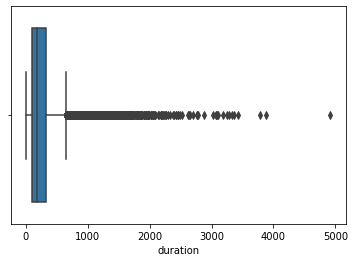

In [ ]:
sns.boxplot(data=raw_data,x='duration')

# **Removing outliers**

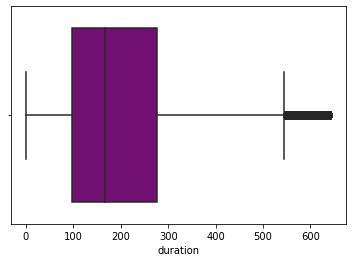

In [ ]:
q3 = raw_data['duration'].quantile(.75)
q1 = raw_data['duration'].quantile(.25)
iqr = q3-q1
iqr
upperrange = q3+1.5*iqr
bottomrange = q1-1.5*iqr
data1 = raw_data[(raw_data['duration']>bottomrange) & (raw_data['duration']<upperrange)] 
sns.boxplot(data=data1,x='duration',color = 'purple')

**Exploratory data analysis**

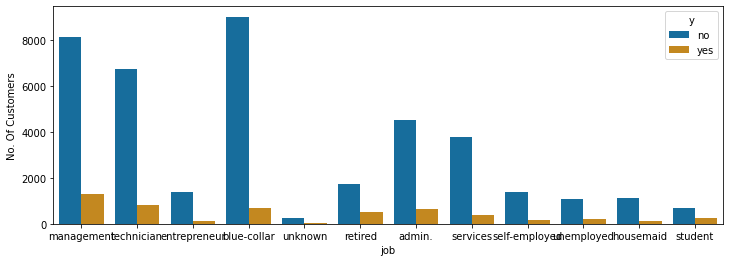

In [ ]:
plt.subplots(figsize=(12,4))
sns.countplot(x ='job', hue = 'y', data = raw_data, palette = 'colorblind')
plt.ylabel('No. Of Customers')
plt.show()

#**Lable encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
for column in raw_data.columns:
        if raw_data[column].dtype == np.number:
            continue
        raw_data[column] = LabelEncoder().fit_transform(raw_data[column])
raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,4,1,2,0,3036,1,0,2,4,8,261,0,0,0,3,0
1,26,9,2,1,0,945,1,0,2,4,8,151,0,0,0,3,0
2,15,2,1,1,0,918,1,1,2,4,8,76,0,0,0,3,0
3,29,1,1,3,0,2420,1,0,2,4,8,92,0,0,0,3,0
4,15,11,2,3,0,917,0,0,2,4,8,198,0,0,0,3,0


# **Correlation visualisation**

<function matplotlib.pyplot.show(*args, **kw)>

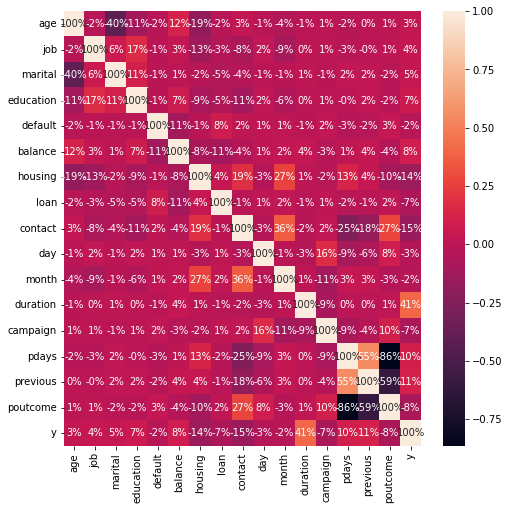

In [ ]:
plt.subplots(figsize=(8,8))
sns.heatmap(raw_data.corr(), annot = True, fmt = '0.0%')
plt.show

# **Splitting data into train and test**

In [ ]:
data=raw_data

In [ ]:
#split data into 70% training and 30% testing.

X = data.iloc[:, 1:data.shape[1]].values
Y = data.iloc[:,0].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 1)
X_train

array([[1, 1, 1, ..., 0, 3, 0],
       [0, 2, 1, ..., 0, 3, 0],
       [9, 1, 1, ..., 0, 3, 0],
       ...,
       [4, 1, 2, ..., 0, 3, 0],
       [0, 1, 3, ..., 0, 3, 0],
       [1, 1, 3, ..., 2, 1, 0]])

**Split Data into independent 'X' and Dependent 'Y' variables**

In [ ]:
#Split the data into independent 'X' and dependent 'Y' variables
X = data.iloc[:, 1:data.shape[1]].values
Y = data.iloc[:, 0].values
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,4,1,2,0,3036,1,0,2,4,8,261,0,0,0,3,0
1,26,9,2,1,0,945,1,0,2,4,8,151,0,0,0,3,0
2,15,2,1,1,0,918,1,1,2,4,8,76,0,0,0,3,0
3,29,1,1,3,0,2420,1,0,2,4,8,92,0,0,0,3,0
4,15,11,2,3,0,917,0,0,2,4,8,198,0,0,0,3,0


**Logistic regression model building**

In [ ]:
#Logistic Regression model building

logmodel=LogisticRegression(solver = 'sag',random_state=100,multi_class='ovr')
logmodel.fit(X_train,Y_train)


LogisticRegression(multi_class='ovr', random_state=100, solver='sag')

In [ ]:
#Training Model Score
logmodel.score(X_train,Y_train)

0.047682244762536734

In [ ]:
#Testing Model Score
logmodel.score(X_test,Y_test)

0.04268652314951342

In [ ]:
#intercept 𝑏₀
logmodel.intercept_

array([-1.71761333e-04, -2.73881120e-04, -4.65000221e-04, -5.98972820e-04,
       -7.59333324e-04, -1.36071070e-03, -1.48520861e-03, -2.29300445e-03,
       -3.26999898e-03, -3.65669613e-03, -3.62024444e-03, -3.62841029e-03,
       -5.25069053e-03, -5.63518890e-03, -6.39484935e-03, -5.73638215e-03,
       -5.71001985e-03, -5.51406256e-03, -5.34278813e-03, -5.54487519e-03,
       -5.39381754e-03, -5.23311779e-03, -4.86785709e-03, -4.92591654e-03,
       -4.55701741e-03, -4.38088580e-03, -4.53008558e-03, -4.68311967e-03,
       -4.39932970e-03, -4.22852906e-03, -4.13548228e-03, -4.14997486e-03,
       -4.32633284e-03, -4.10312810e-03, -4.03439881e-03, -4.56050829e-03,
       -4.04103844e-03, -3.91815986e-03, -3.61830757e-03, -4.36670364e-03,
       -4.31742444e-03, -4.10429104e-03, -3.65986867e-03, -1.41341710e-03,
       -8.01761100e-04, -1.03347187e-03, -7.91031827e-04, -8.07574260e-04,
       -7.97938874e-04, -7.44800958e-04, -6.71800858e-04, -5.80281007e-04,
       -1.08025729e-03, -

In [ ]:
#slope 𝑏₁
logmodel.coef_

array([[-6.27260326e-04, -1.27148107e-04, -2.01690744e-04, ...,
        -1.98580643e-05, -4.87963675e-04,  2.77444890e-05],
       [-5.19541616e-04, -1.12370766e-04, -3.17132285e-04, ...,
        -5.48628899e-05, -7.78682436e-04,  6.26365563e-05],
       [-1.23019542e-03, -2.61599088e-04, -4.17972597e-04, ...,
         8.55690900e-05, -1.41105808e-03,  1.03792113e-04],
       ...,
       [-7.01471066e-04, -1.49605662e-04, -1.66707582e-04, ...,
         7.79613939e-05, -4.23009408e-04,  1.34655209e-05],
       [-5.51174484e-04, -1.23524372e-04, -1.53765408e-04, ...,
        -3.36852092e-05, -3.19594120e-04, -1.29770745e-06],
       [-4.64360647e-04, -9.72206598e-05, -1.30723186e-04, ...,
        -2.93552543e-05, -2.69544745e-04, -1.25462903e-06]])

**In the matrix below, each row corresponds to a single observation.
The first column is the probability of the predicted output being zero, that is 1 - 𝑝(𝑥).
The second column is the probability that the output is one, or 𝑝(𝑥).**

In [ ]:
logmodel.predict_proba(X)

array([[1.96763597e-10, 6.98458088e-08, 8.32877303e-07, ...,
        2.82654834e-13, 8.64024692e-15, 1.12380558e-20],
       [7.05003048e-05, 4.25834575e-04, 1.03246302e-03, ...,
        1.10463733e-05, 3.02685913e-06, 5.00434742e-08],
       [1.56526270e-04, 9.10897845e-04, 1.87721561e-03, ...,
        2.15370023e-05, 7.59511017e-06, 1.25765907e-07],
       ...,
       [3.10660695e-20, 1.17703799e-15, 3.10576007e-13, ...,
        1.60449714e-24, 3.79026307e-28, 3.06288093e-38],
       [7.72861559e-08, 1.44990496e-06, 1.05086785e-05, ...,
        6.76370701e-09, 3.54705557e-10, 5.54863305e-13],
       [1.49503720e-12, 2.59668723e-09, 5.25545662e-08, ...,
        5.86963878e-16, 6.15116586e-18, 3.26902621e-25]])

**This function returns the predicted output values as a one-dimensional array**

In [ ]:
logmodel.predict(X)

array([14, 14, 14, ..., 14, 14, 14])

**Select columns**

In [ ]:
columns = ['age', 'balance', 'duration', 'campaign', 'y']
data = data[columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       45211 non-null  int64
 1   balance   45211 non-null  int64
 2   duration  45211 non-null  int64
 3   campaign  45211 non-null  int64
 4   y         45211 non-null  int64
dtypes: int64(5)
memory usage: 1.7 MB


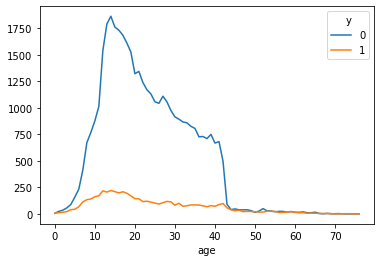

In [ ]:
pd.crosstab(data.age,data.y).plot(kind="line")

**graph shows that age group 20-60 has more rejection of application while 60-90 almost everybody**

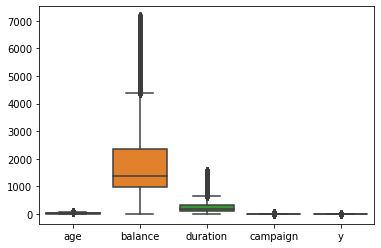

In [ ]:
sns.boxplot(data =data,orient = "v")

In [ ]:
data['outcome'] = data.y.map({'no':0, 'yes':1})
data.tail(10)

,age,balance,duration,campaign,y,outcome
45201,35,1499,226,0,1,NaN
45202,16,1473,224,0,1,NaN
45203,5,1029,266,0,1,NaN
45204,55,3678,300,0,1,NaN
45205,7,1421,386,1,1,NaN
45206,33,1741,975,2,1,NaN
45207,53,2639,456,1,1,NaN
45208,54,5455,1116,4,1,NaN
45209,39,1584,508,3,0,NaN
45210,19,3779,361,1,0,NaN


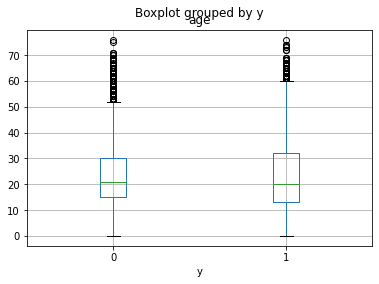

In [ ]:
data.boxplot(column='age', by='y')

Probably not a great feature since lot of outliers

In [ ]:
feature_col=['age','balance','duration','campaign']
output_target=['y']
X = data[feature_col]
Y = data[output_target]

In [ ]:
X

,age,balance,duration,campaign
0,40,3036,261,0
1,26,945,151,0
2,15,918,76,0
3,29,2420,92,0
4,15,917,198,0
...,...,...,...,...
45206,33,1741,975,2
45207,53,2639,456,1
45208,54,5455,1116,4
45209,39,1584,508,3


In [ ]:
Y

,y
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


In [ ]:
classifier = LogisticRegression()

In [ ]:
classifier.fit(X,Y)

LogisticRegression()

In [ ]:
classifier.coef_

array([[ 0.00645921,  0.00014586,  0.00378861, -0.13889787]])

In [ ]:
classifier.predict_proba (X) # Probability values 

array([[0.8657842 , 0.1342158 ],
       [0.93561726, 0.06438274],
       [0.95415219, 0.04584781],
       ...,
       [0.22050091, 0.77949909],
       [0.82683304, 0.17316696],
       [0.83909254, 0.16090746]])

In [ ]:
y_pred = classifier.predict(X)

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
confusion_matrix = cm(Y,y_pred)

In [ ]:
print (confusion_matrix)

[[39269   653]
 [ 4351   938]]


Text(0.5, 15.0, 'Predicted Label')

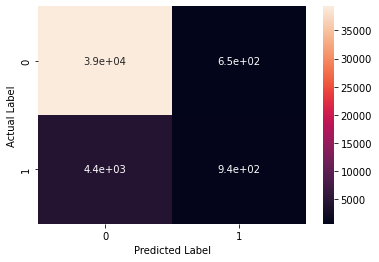

In [ ]:
sns.heatmap(confusion_matrix, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

In [ ]:
#plotting confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,logmodel.predict(X_test))
TN = cm[0][0]
FN = cm[1][0]
FP = cm[0][1]
TP = cm[1][1]
print(cm)
print('The model testing accuracy = {}'.format((TP+TN)/(TP+TN+FN+FP)))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
The model testing accuracy = nan


<function matplotlib.pyplot.show(*args, **kw)>

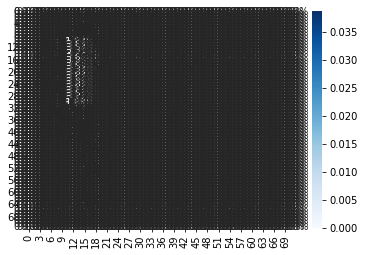

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')
plt.show

**Conclusion**
To summarize the article, we learned why to use logistic regression algorithm and how to perform it using python. I also learned the flow and necessary steps to take before building the logistic regression model. This was a basic logistic regression model.
Further, to enhance the model for better results, you need to apply resampling techniques such as oversampling, undersampling or SMOTE when dealing with such imbalanced datasets. Imbalanced data means datasets where the target class has an uneven distribution of observations, i.e. in our case, the variable Term Deposit subscription status has two classes. The class “no” has a very high number of observations, and the clas ‘yes” one class label has a very high number of observations, and the other has a very low number of observations